In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import sys
import time
sys.path.insert(1, '/home/nicolas/code/src')
sys.path.insert(1, '/home/nicolas/code/data')

from TMCRBM import TMCRBM
from scipy.integrate import simps
from scipy import stats


device = torch.device("cuda")
dtype = torch.float
torch.set_num_threads(4)

In [2]:
W = np.genfromtxt('../dataset/C1d5c/rbm_W.dat').T
vbias = np.genfromtxt('../dataset/C1d5c/rbm_vis.dat')
hbias = -np.genfromtxt('../dataset/C1d5c/rbm_hid.dat')
data = np.genfromtxt('../dataset/C1d5c/data_5.dat')
data = (data+1)/2

lr = 0.01
l2 = 0
NGibbs = 10
annSteps = 0
mb_s = 500
num_pcd = 500
Nh = W.shape[0]
Nv = W.shape[1]
print(Nh)
ep_max = 100
myRBM = TMCRBM(num_visible=Nv,
				num_hidden=Nh,
				device=device,
				lr=lr,
				#regL2=l2,
				gibbs_steps=NGibbs,
				#anneal_steps=annSteps,
				UpdCentered=True,
				mb_s=mb_s,
				num_pcd=num_pcd)

myRBM.W = torch.tensor(4*W).float().cuda()
myRBM.vbias = torch.tensor(2*vbias - 2*W.sum(0)).float().to(device)
myRBM.hbias = torch.tensor(2*hbias - 2*W.sum(1)).float().to(device)
_, _, V = torch.svd(torch.tensor(4*W).float().cuda())


20


In [3]:
#w_hat : ndim x npoint 
def TMCSample2D(v, w_hat, N, V, it_mcmc=100, it_mean=50, ß=1):
    #print("Initialisation")
    #s = time.time()
    vtab = torch.zeros(v.shape, device = device)
    v_curr = v
    #V = V
    norm = 1/(v_curr.shape[0]**0.5)
    w_curr = torch.zeros(w_hat.shape )
    
    w_curr = (torch.mm(v_curr.T, V)*norm)[:,:w_hat.shape[0]]
    
    index = torch.randperm(v_curr.shape[0])
    #print(time.time()-s)
    #print("IT MCMC")
    #s = time.time()

    for t in range(it_mcmc):
        #print('init it')
        print(t)
        h_curr, _ = myRBM.SampleHiddens01(v_curr)
        h_i = (torch.mm(myRBM.W.T, h_curr)+myRBM.vbias.reshape(v.shape[0],1)) # Nv x Ns
        w_next = w_curr.clone()
        
        v_next = torch.clone(v_curr)
        index = torch.randperm(v_curr.shape[0])
        for idx in range(v_curr.shape[0]):
            #print('upd comp')
            s = time.time()
            i = idx
            v_next[i,:] = 1-v_curr[i,:]
            w_next[:,0] += ((2*v_next[i,:]-1)*V[i,0]*norm)
            w_next[:,1] += ((2*v_next[i,:]-1)*V[i,1]*norm)

            # On calcul -DeltaE
            ΔE = ß*((2*v_next[i,:]-1)*h_i[i,:])-(N/2)*(torch.sum((w_hat.T-w_next)**2, dim=1)-torch.sum((w_hat.T-w_curr)**2, dim=1))

            tir = torch.rand(v_curr.shape[1],1, device = torch.device("cuda")).squeeze()
            prob = torch.exp(ΔE).squeeze()
            v_curr[i,:] = torch.where(tir<prob, v_next[i,:], v_curr[i,:])
            v_next[i,:] = torch.where(tir<prob, v_next[i,:], 1-v_next[i,:])
            neg_index = torch.ones(w_curr.shape[0], dtype = bool)
            index = torch.where(tir<prob)[0]
            neg_index[index] = False
            w_curr[index,:]=  w_next[index, :]
            w_next[neg_index,:] =  w_curr[neg_index,:]
            #print(time.time()-s)
        if (t>= (it_mcmc-it_mean)):
            vtab += v_curr
    print(time.time()-s)

    vtab = vtab*(1/it_mean)    
    return v_curr, h_curr, vtab

In [4]:
vinit = torch.bernoulli(torch.rand(
        (myRBM.Nv, 1000), device=myRBM.device, dtype=myRBM.dtype))
#vinit = torch.where(V_g[:,0]>0, 1, 0).repeat(2000).reshape(myRBM.Nv, 2000).float()
#vinit = data.T
si, _, _, _ = myRBM.Sampling(vinit, it_mcmc=1000)


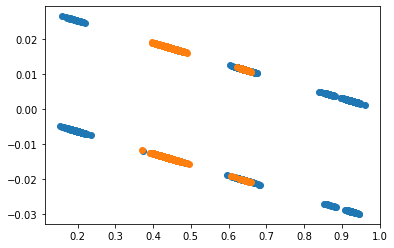

In [5]:
_, _, V_g = torch.svd(myRBM.W)
if torch.mean(V_g[:,0])<0:
    V_g = -V_g
proj_gen = torch.mm(si.T, V_g).cpu().numpy()/myRBM.Nv**0.5
proj_data =torch.mm(torch.tensor(data, device= device, dtype = dtype), V_g).cpu()/myRBM.Nv**0.5
plt.scatter(proj_data[:,0].cpu().numpy(), proj_data[:,1].cpu().numpy());
plt.scatter(proj_gen[:,0], proj_gen[:,1])


In [6]:
nb_chain = 10 # Nb de chaines pour chaque w_hat
it_mcmc = 100 # Nb it_mcmc pour chaque chaine
it_mean = 90 # Nb it considérée pour la moyenne temporelle de chaque chaine
N = 10000 # Contrainte
nb_point_x = 100 # Nb de points de discrétisation pour w_hat
nb_point_y = 50
width_plus = 0.4
xmin = proj_data[:,0].min()-width_plus
xmax = proj_data[:,0].max()+width_plus
ymin = proj_data[:,1].min()-width_plus
ymax = proj_data[:,1].max()+width_plus
nb_point = nb_point_x*nb_point_y

In [7]:
x_grid = np.linspace(xmin, xmax, nb_point_x)
x_grid = np.array([x_grid for i in range(nb_point_y)])
x_grid = x_grid.reshape(nb_point)
y_grid = []
y_d = np.linspace(ymin, ymax, nb_point_x)
for i in range(nb_point_x):
    for j in range(nb_point_y):
        y_grid.append(y_d[i])
grid = torch.tensor([x_grid, y_grid], device = device, dtype = dtype)
grid.shape

torch.Size([2, 5000])

In [8]:
start = torch.bernoulli(torch.rand(myRBM.Nv, nb_chain*nb_point, device = device))
V0 = V_g
# w_hat = torch.dot(start.T, V)[0:,]
w_hat_b = grid
w_hat = torch.zeros((2, nb_chain*nb_point), device = device)
for i in range(nb_point):
    for j in range(nb_chain):
        w_hat[:,i*nb_chain+j] = w_hat_b[:,i]
tmpv, tmph, vtab = TMCSample2D(start, w_hat, N, V0, it_mcmc = it_mcmc, it_mean=it_mean)


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
0.0008015632629394531


In [9]:
y = torch.tensor(torch.mm(vtab.T, V0)[:,:2].cpu())/myRBM.Nv**0.5
newy = torch.tensor([torch.mean(y[i*nb_chain:i*nb_chain+nb_chain,:], dim = 0).cpu().numpy() for i in range(nb_point)])
w_hat = w_hat.cpu().numpy()
w_hat_b = w_hat_b.cpu().numpy()

<ipython-input-9-f6dad6b7333e>:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(torch.mm(vtab.T, V0)[:,:2].cpu())/myRBM.Nv**0.5


In [10]:
grad_pot = newy.T-w_hat_b
square = torch.zeros(2, nb_point_x, nb_point_y)
w_hat_tmp = np.zeros((2, nb_point_x, nb_point_y))
for i in range(0,grad_pot.shape[1], nb_point_x):
        #print("I : ", i/nb_point_x)
        #print("s : ", (i*nb_point_x))
        #print("e : ", (i*nb_point_x+nb_point_x))
        w_hat_tmp[:,:,int(i/nb_point_x)] = w_hat_b[:, i:(i+nb_point_x)]
        square[:,:, int(i/nb_point_x)] = grad_pot[:,i:(i+nb_point_x)]
#square = grad_pot.reshape(2,nb_point_x, nb_point_y)
w_hat_x = np.linspace(xmin, xmax, nb_point_x)
w_hat_y = np.linspace(ymin, ymax, nb_point_y)

#calcul de l'intégrale sur w_1
res_x = np.zeros((nb_point_x,nb_point_y))
for j in range(1,nb_point_y):
    for i in range(1, nb_point_x):
        res_x[i,j] = simps(square[0,:i,j].cpu().numpy(), w_hat_x[:i])

res_x = res_x


#calcul de l'intégrale sur w_2
res_y = np.zeros((nb_point_x, nb_point_y))
for i in range(1, nb_point_x):
    for j in range(1, nb_point_y):
        res_y[i,j] = simps(square[1,i,:j].cpu().numpy(), w_hat_y[:j])
res_y = res_y
pot = res_x + res_y
pot = pot.T
res = np.exp(N*(pot-np.max(pot)))

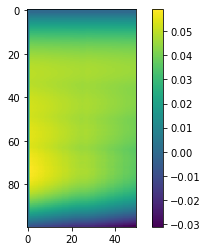

In [11]:
plt.imshow(res_x[:,:])
plt.colorbar()

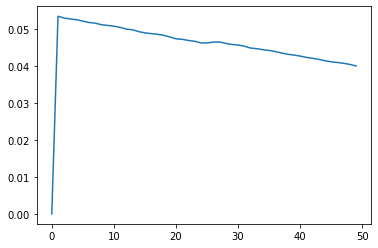

In [12]:
plt.plot(res_x[50,:])

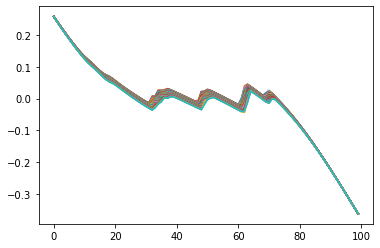

In [13]:
plt.plot(square[0,:])

In [14]:
#LE CALCUL DE LA CONSTANTE EST CORRECT
const = np.zeros(res.shape[0]-1)
for i in range(1, res.shape[0]):
    const[i-1] = simps(res[:,i], w_hat_y)
const = simps(const, w_hat_y[:-1])
p_m = res/const

In [15]:
tmp = np.zeros(p_m.shape[0]-1)
for i in range(1, p_m.shape[0]-1):
    tmp[i-1] = simps(p_m[:,i], w_hat_y)
tmp = simps(tmp, w_hat_y[:-1])
print("Integrale de la proba sur l'espace : ", tmp)

Integrale de la proba sur l'espace :  0.9999999999999999


0.0

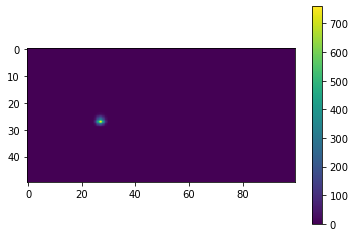

In [16]:
plt.imshow(p_m)
plt.colorbar()
p_m.min()

<ipython-input-17-0e6ab95260a1>:2: RuntimeWarning: divide by zero encountered in log
  plt.plot(np.log(p_m)[30,:])


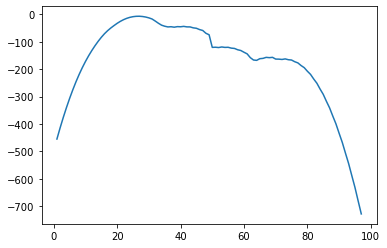

In [17]:
#plt.plot(np.exp(N*res_x[:,30]))
plt.plot(np.log(p_m)[30,:])

<ipython-input-18-e355688eb380>:3: RuntimeWarning: divide by zero encountered in log
  plt.imshow(np.log(p_m), extent = [xmin, xmax, ymin, ymax])


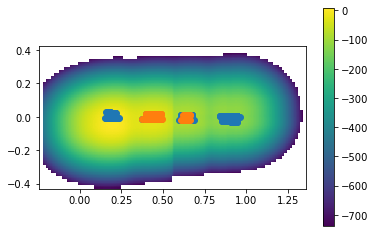

In [18]:
plt.scatter(proj_data[:,0].cpu().numpy(), proj_data[:,1].cpu().numpy());
plt.scatter(proj_gen[:,0], proj_gen[:,1])
plt.imshow(np.log(p_m), extent = [xmin, xmax, ymin, ymax])
plt.xticks()

plt.colorbar()

<ipython-input-19-b5f7a051814c>:1: RuntimeWarning: divide by zero encountered in log
  plt.imshow(np.log(res), extent = [xmin, xmax, ymin, ymax])


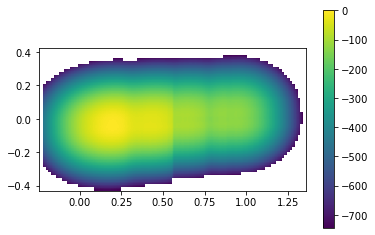

In [19]:
plt.imshow(np.log(res), extent = [xmin, xmax, ymin, ymax])
plt.colorbar()

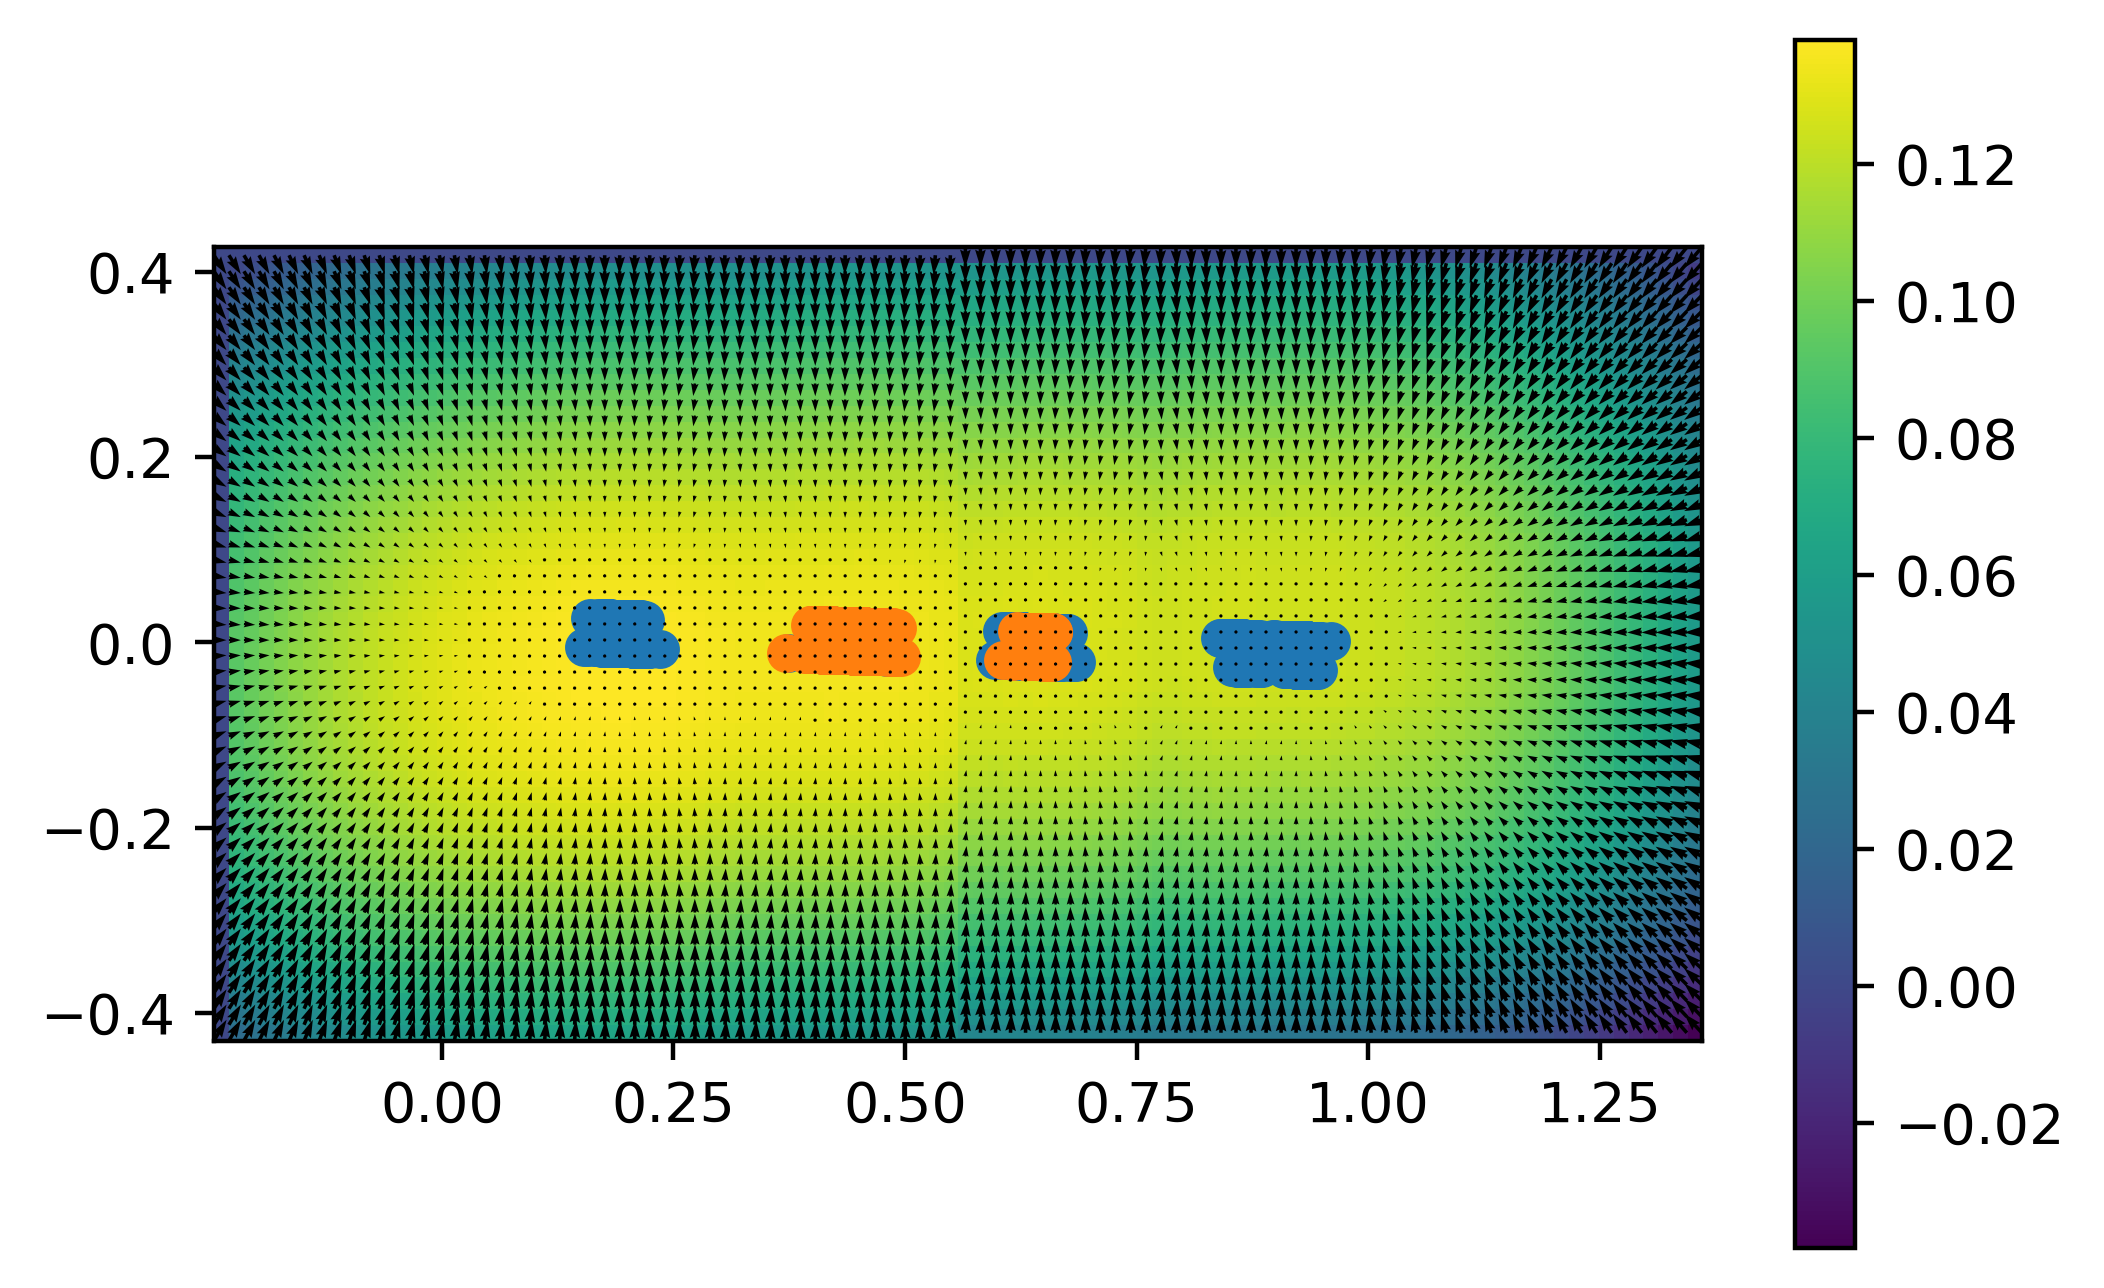

In [20]:
plt.figure(dpi = 400)

plt.scatter(proj_data[:,0].cpu().numpy(), proj_data[:,1].cpu().numpy());
plt.scatter(proj_gen[:,0], proj_gen[:,1])
plt.quiver(w_hat_b[0,:], w_hat_b[1,:], grad_pot[0,:], grad_pot[1,:])
plt.imshow(pot, extent = [xmin, xmax, ymin, ymax] )
#plt.quiver(w_hat_b[0,:], w_hat_b[1,:], pot.reshape(2500)[:], pot.reshape(2500)[1,:])
plt.colorbar()